# 1- Repository Setup and data processing

#### Link of the repository: https://github.com/wiricardo/Hospitals-Access-Peru

##### Initial setup to visualize HTML in VS Code

In [35]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }a
</style>
"""))

# Libraries

In [36]:
import numpy as np
import chardet
import matplotlib.patches as mpatches
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import folium as fm
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap, StripePattern
from IPython.display import IFrame

### Reading, handling and processing IPRESS.csv

In [37]:
base = open('../data/IPRESS.csv', 'rb').read()
det = chardet.detect(base)
charenc = det['encoding']
charencbase = open('../data/IPRESS.csv', 'rb').read()
det = chardet.detect(base)
charenc = det['encoding']
charenc

'MacRoman'

In [38]:
csv_data = pd.read_csv('../data/IPRESS.csv', encoding=charenc)
csv_data = csv_data.rename(columns={
    'InstituciÛn':'INSTITUCIÓN',
    'Nombre del establecimiento': 'NOMBRE DEL ESTABLECIMIENTO',
    'ClasificaciÛn':'CLASIFICACION',
    'Departamento':'DEPARTAMENTO',
    'Provincia':'PROVINCIA',
    'Distrito':'DISTRITO',
    'Estado':'ESTADO',
    'NORTE':'LATITUD',
    'ESTE':'LONGITUD'
})

In [39]:
cleaned_csv = csv_data.loc[csv_data['ESTADO'] == 'ACTIVADO'].dropna(subset=['LATITUD', 'LONGITUD'])

In [40]:
publicos_op = cleaned_csv.loc[
    (cleaned_csv['INSTITUCIÓN'].ne('PRIVADO')) &
    (cleaned_csv['INSTITUCIÓN'].ne('OTRO')) &
    (cleaned_csv['CondiciÛn'].eq('EN FUNCIONAMIENTO'))
].copy()

publicos_op['DISTRITO'] = publicos_op['DISTRITO'].str.strip().str.upper()


In [41]:
conteo_ubigeo = (
    publicos_op.groupby('UBIGEO')
    .size()
    .reset_index(name='CANTIDAD')
)

#### Distritos Shape file 

In [42]:
maps = gpd.read_file('../data/distritos/DISTRITOS.shp')[['IDDIST', 'geometry']]
maps = maps.rename(columns={'IDDIST':'UBIGEO'})
maps['UBIGEO'] = maps['UBIGEO'].astype(str).astype(int)
maps = maps.to_crs(epsg=4326)

#### Merged data

In [43]:
distritos = maps.merge(conteo_ubigeo, on='UBIGEO', how='left')
distritos['CANTIDAD'] = distritos['CANTIDAD'].fillna(0).astype(int)

# 2- Geospatial Analysis with GeoPandas

### Task 1: Static maps: count of hospitals by district

#### Map 1: Total public hospitals per district.

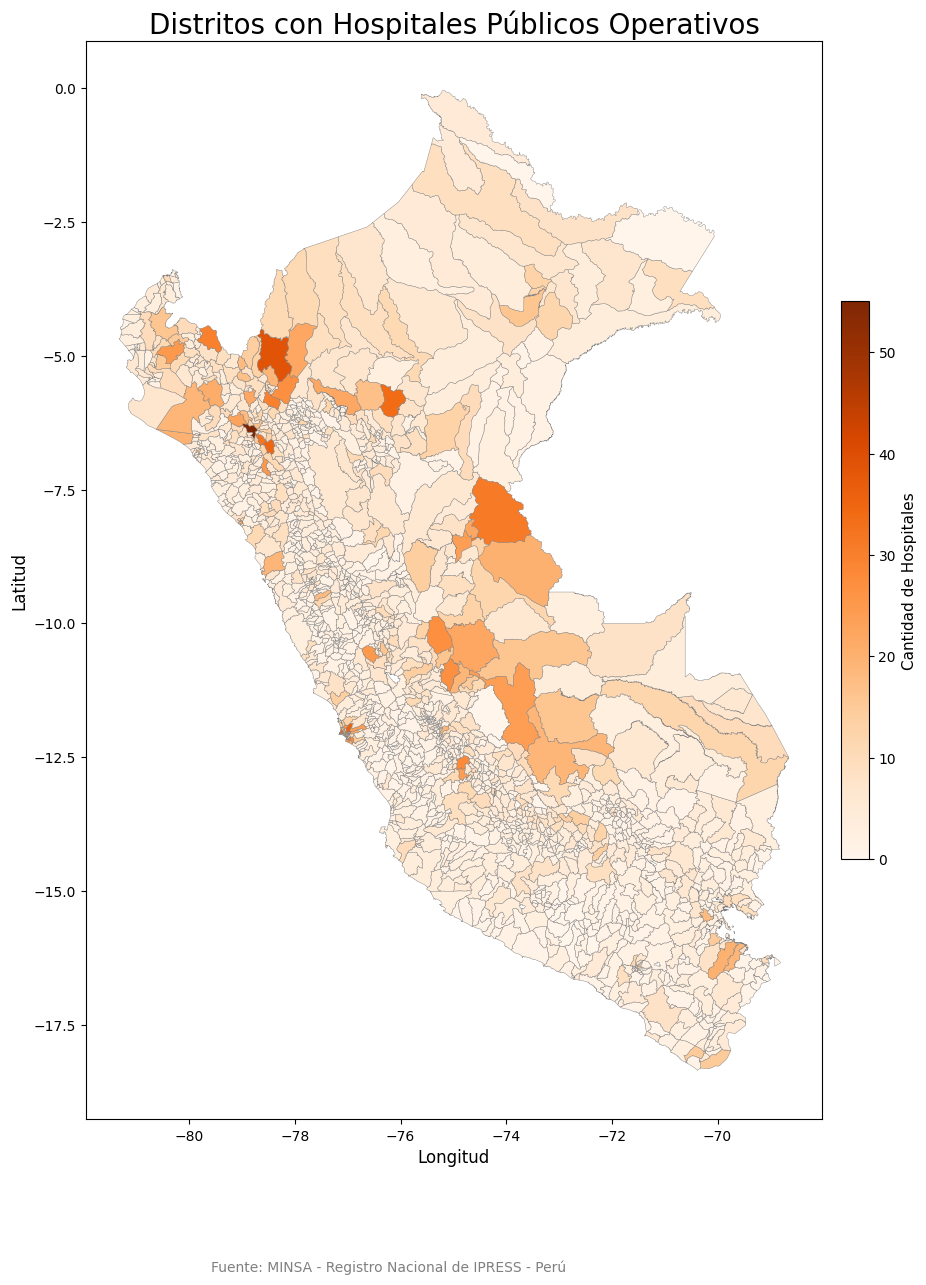

In [44]:
fig, ax = plt.subplots(figsize=(12, 14))

distritos.plot(
    column='CANTIDAD',
    cmap='Oranges',
    linewidth=0.3,
    edgecolor='gray',
    legend=False,
    ax=ax
)

ax.set_title('Distritos con Hospitales Públicos Operativos', fontsize=20)
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)

norm = colors.Normalize(vmin=distritos['CANTIDAD'].min(), vmax=distritos['CANTIDAD'].max())
sm = cm.ScalarMappable(cmap='Oranges', norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('Cantidad de Hospitales', fontsize=11)

fig.text(0.5, 0.001, "Fuente: MINSA - Registro Nacional de IPRESS - Perú",
         ha="center", fontsize=10, color="gray")


fig.savefig('../output/map_1.png', dpi=300, bbox_inches='tight')
plt.show()

#### Map 2: Highlight districts with zero hospitals

/var/folders/2w/49y_fhrn5hx6ld44gwry6v680000gn/T/ipykernel_1713/2842490593.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')
/var/folders/2w/49y_fhrn5hx6ld44gwry6v680000gn/T/ipykernel_1713/2842490593.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower left')


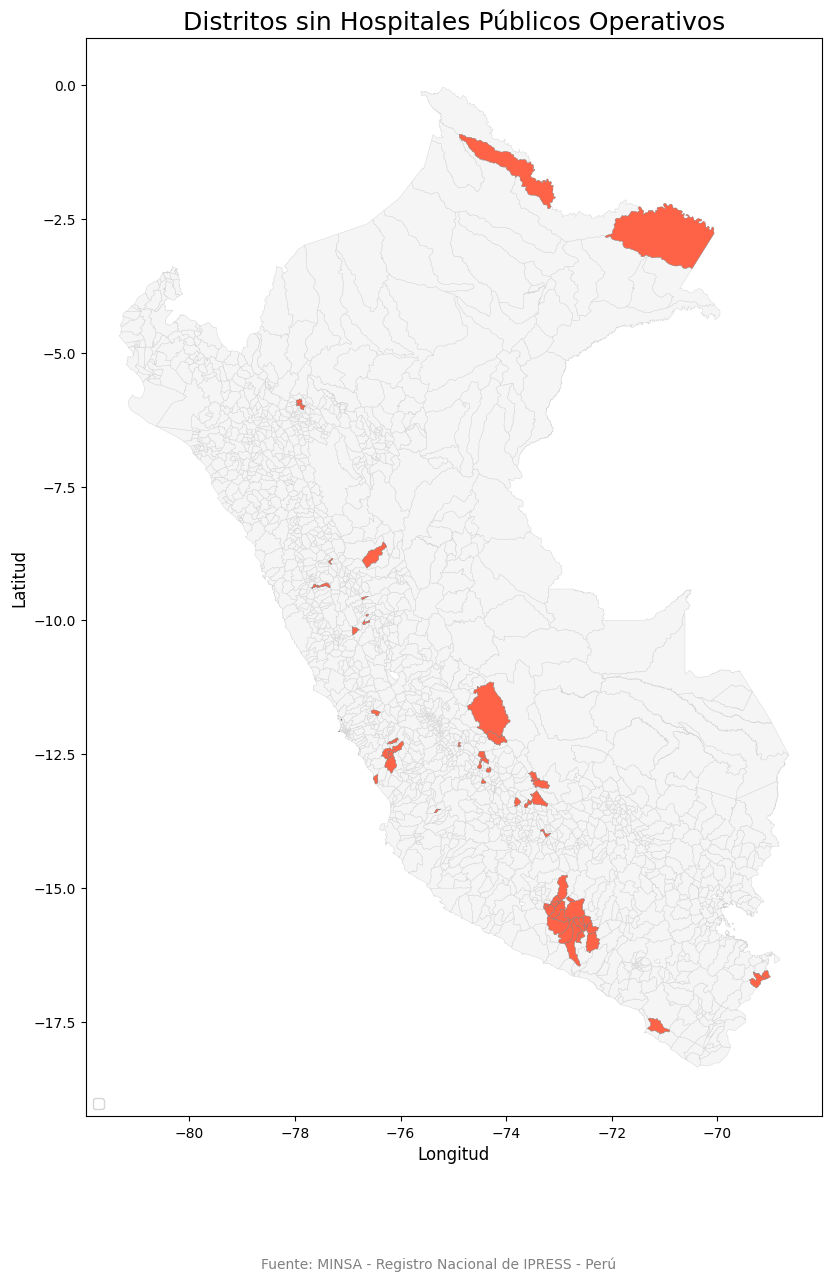

In [45]:
distritos['HOSPITALES'] = (distritos['CANTIDAD'] > 0).map({True: 'Con hospitales', False: 'Sin hospitales'})

fig, ax = plt.subplots(figsize=(12, 14))


distritos.plot(ax=ax, color='whitesmoke', edgecolor='lightgray', linewidth=0.3)


distritos.loc[distritos['CANTIDAD'].eq(0)].plot(
    ax=ax, color='tomato', edgecolor='gray', linewidth=0.3, label='Sin hospitales'
)

ax.legend(loc='lower left')
ax.set_title('Distritos sin Hospitales Públicos Operativos', fontsize=18)
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)

fig.text(0.5, 0.001, "Fuente: MINSA - Registro Nacional de IPRESS - Perú",
         ha="center", fontsize=10, color="gray")

fig.savefig('../output/map_2.png', dpi=300, bbox_inches='tight')
plt.show()

#### Map 3: Top 10 districts with the highest number of hospitals (distinct color scale).

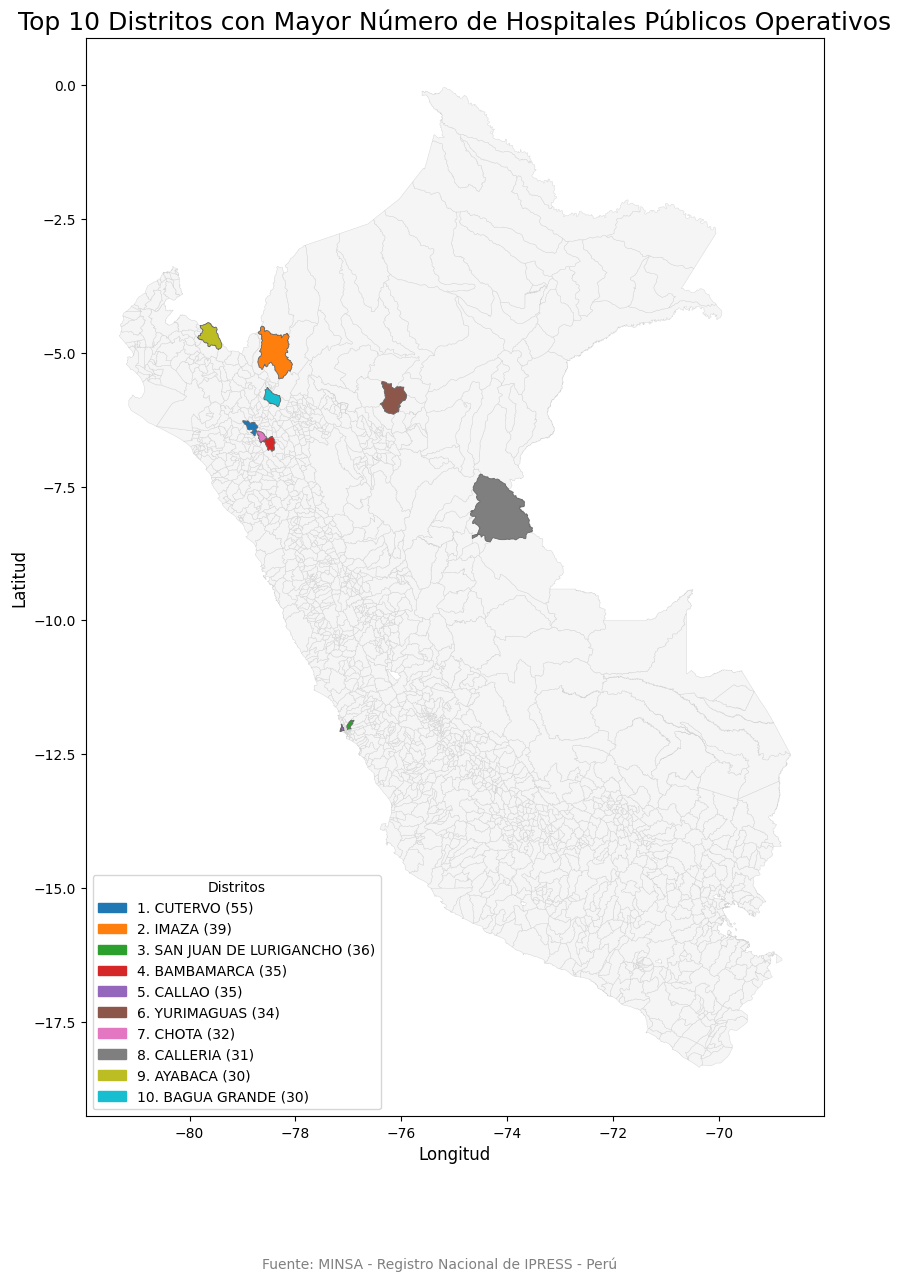

In [46]:
if 'DISTRITO' not in distritos.columns:
    nombres = (cleaned_csv[['UBIGEO', 'DISTRITO']]
               .dropna(subset=['UBIGEO', 'DISTRITO'])
               .drop_duplicates('UBIGEO')
               .copy())
    nombres['DISTRITO'] = nombres['DISTRITO'].str.strip().str.upper()
    distritos = distritos.merge(nombres, on='UBIGEO', how='left')


top10 = distritos.sort_values('CANTIDAD', ascending=False).head(10).copy()
top10['RANK'] = np.arange(1, len(top10) + 1)


fig, ax = plt.subplots(figsize=(12, 14))
distritos.plot(ax=ax, color='whitesmoke', edgecolor='lightgray', linewidth=0.3)


cmap = plt.get_cmap('tab10')
top10.plot(
    ax=ax,
    column='RANK',
    categorical=True,
    cmap=cmap,
    linewidth=0.6,
    edgecolor='dimgray'
)


handles = []
for _, row in top10.iterrows():
    color = cmap((row['RANK'] - 1) % 10)
    nombre = row.get('DISTRITO', f"UBIGEO {row['UBIGEO']}")
    label = f"{int(row['RANK'])}. {nombre} ({int(row['CANTIDAD'])})"
    handles.append(mpatches.Patch(color=color, label=label))
ax.legend(handles=handles, title="Distritos", loc='lower left', frameon=True)

ax.set_title('Top 10 Distritos con Mayor Número de Hospitales Públicos Operativos', fontsize=18)
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)
fig.text(0.5, 0.001, "Fuente: MINSA - Registro Nacional de IPRESS - Perú",
         ha="center", fontsize=10, color="gray")

fig.savefig('../output/map_3.png', dpi=300, bbox_inches='tight')
plt.show()

### Task 2: Department-level Analysis

#### A summary table (sorted from highest to lowest).

In [47]:
dept_counts = (
    publicos_op.groupby('DEPARTAMENTO')
    .size()
    .reset_index(name='TOTAL_HOSPITALES')
    .sort_values('TOTAL_HOSPITALES', ascending=False)
)
max_dept = dept_counts.iloc[0]
min_dept = dept_counts.iloc[-1]
dept_counts.to_csv("../output/operationao_hospitals_by_department.csv", index=False, encoding="utf-8")

In [48]:
display(dept_counts)
print(f"Departamento con mas hospitales: {max_dept['DEPARTAMENTO']} ({max_dept['TOTAL_HOSPITALES']})")
print(f"Departamento con men hospitales: {min_dept['DEPARTAMENTO']} ({min_dept['TOTAL_HOSPITALES']})")

,DEPARTAMENTO,TOTAL_HOSPITALES
5,CAJAMARCA,840
14,LIMA,751
11,JUNIN,487
19,PIURA,426
1,ANCASH,413
20,PUNO,405
0,AMAZONAS,400
4,AYACUCHO,386
2,APURIMAC,374
21,SAN MARTIN,373


Departamento con mas hospitales: CAJAMARCA (840)
Departamento con men hospitales: TUMBES (51)


#### A bar chart 

/var/folders/2w/49y_fhrn5hx6ld44gwry6v680000gn/T/ipykernel_1713/1407907244.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


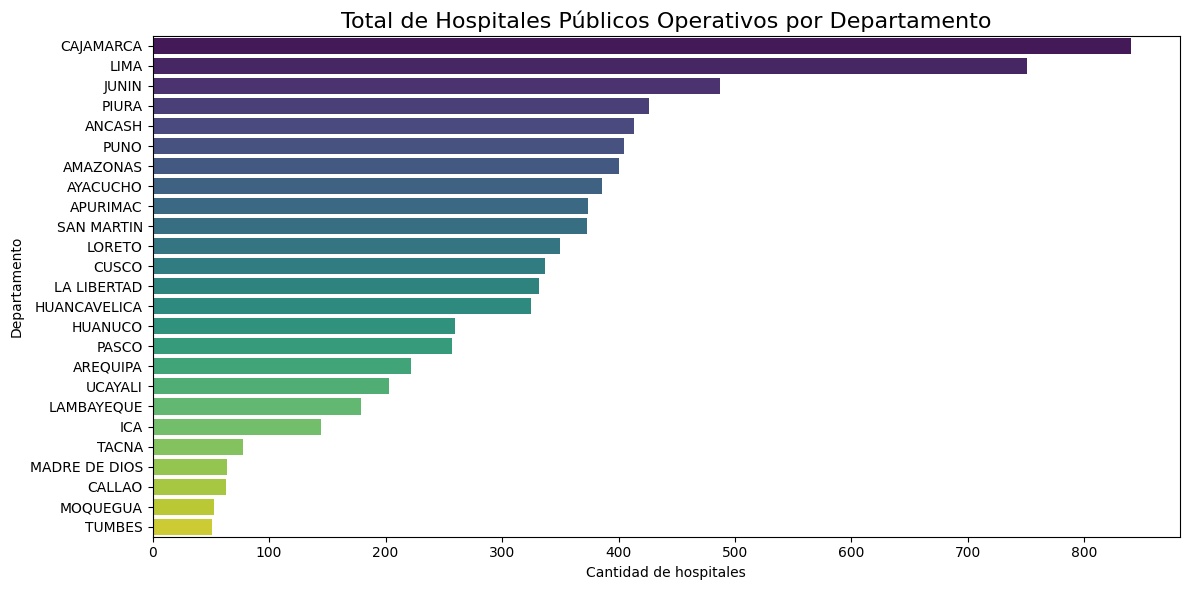

In [49]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=dept_counts,
    x='TOTAL_HOSPITALES',
    y='DEPARTAMENTO',
    palette='viridis'
)
plt.title("Total de Hospitales Públicos Operativos por Departamento", fontsize=16)
plt.xlabel("Cantidad de hospitales")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

fig.savefig('../output/map_bar_chart.png', dpi=300, bbox_inches='tight')

#### A department-level choropleth map (GeoPandas)

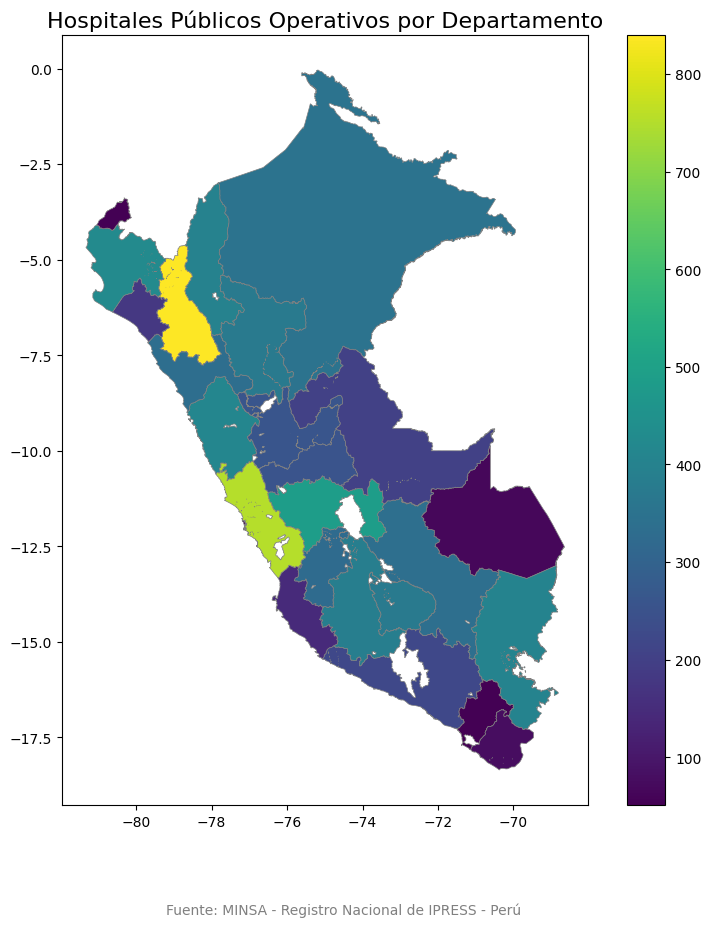

In [50]:

dept_drop_dup = publicos_op[['UBIGEO', 'DEPARTAMENTO']].drop_duplicates()

maps_dept = maps.merge(dept_drop_dup, on='UBIGEO', how='left')

departamentos_shp = maps_dept.dissolve(by='DEPARTAMENTO', as_index=False)


departamentos_shp['DEPARTAMENTO'] = departamentos_shp['DEPARTAMENTO'].str.strip().str.upper()
dept_counts['DEPARTAMENTO'] = dept_counts['DEPARTAMENTO'].str.strip().str.upper()


dept_map = departamentos_shp.merge(dept_counts, on='DEPARTAMENTO', how='left')
dept_map['TOTAL_HOSPITALES'] = dept_map['TOTAL_HOSPITALES'].fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(10,10))
dept_map.plot(
    column='TOTAL_HOSPITALES',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title("Hospitales Públicos Operativos por Departamento", fontsize=16)
fig.text(0.5, 0.001, "Fuente: MINSA - Registro Nacional de IPRESS - Perú",
         ha="center", fontsize=10, color="gray")

fig.savefig('../output/map_department_level_choropleth_map.png', dpi=300, bbox_inches='tight')
plt.show()



### Task 3: Proximity Analysis (using Population Centers)

##### Getting the centroid

In [51]:
pop_center = gpd.read_file('../data/CCPP_0/CCPP_IGN100K.shp')
pop_center.rename(columns={'X':'LONGITUD', 'Y':'LATITUD', 'DEP':'DEPARTAMENTO'}, inplace=True)
pop_center.head()


,OBJECTID,NOM_POBLAD,FUENTE,CÓDIGO,CAT_POBLAD,DIST,PROV,DEPARTAMENTO,CÓD_INT,CATEGORIA,LONGITUD,LATITUD,N_BUSQDA,geometry
0,1,PANDISHARI,INEI,2502010002,OTROS,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.06462,-10.37129,PANDISHARI,POINT (-74.06462 -10.37129)
1,2,CHICOSA,INEI,2502010003,OTROS,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.06153,-10.37852,CHICOSA,POINT (-74.06153 -10.37852)
2,3,RAYA,IGN,2502010004,OTROS,RAYMONDI,ATALAYA,UCAYALI,2350,Centro Poblado Menor,-72.94118,-10.33043,RAYA,POINT (-72.94118 -10.33043)
3,4,PENSILVANIA,INEI,2502010005,OTROS,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.05988,-10.40401,PENSILVANIA,POINT (-74.05988 -10.40401)
4,5,PONTE VEDRA,INEI,2502010006,CASERÍO,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.03788,-10.41809,PONTE VEDRA,POINT (-74.03787 -10.41809)


##### Reverse names to avoid compatibility errors with folium 

In [52]:
publicos_op_est = publicos_op.rename(columns={
    'LATITUD': 'LONGITUD',
    'LONGITUD': 'LATITUD'
}).copy()

##### Hospitals in GeoDataFrame WGS84

In [53]:
hosp = publicos_op_est.copy()
hosp = hosp.dropna(subset=['LONGITUD','LATITUD'])
hosp = hosp[~((hosp['LONGITUD']==0) & (hosp['LATITUD']==0))]

hosp_gdf = gpd.GeoDataFrame(
    hosp,
    geometry=gpd.points_from_xy(hosp['LONGITUD'], hosp['LATITUD']),
    crs="EPSG:4326"
)

##### Lima analysis

In [54]:
# Filtrar centros poblados de Lima
pc_lima = pop_center[pop_center['DEPARTAMENTO'].str.upper().str.strip() == 'LIMA'].copy()

# Proyectar para distancias en metros
pc_lima_utm   = pc_lima.to_crs(32718)
hosp_lima_utm = hosp_gdf.to_crs(32718)

# Centroides y buffers
pc_lima_utm['pc_id'] = pc_lima_utm.index
pc_lima_centroids = pc_lima_utm.copy()
pc_lima_centroids['geometry'] = pc_lima_centroids.geometry.centroid


pc_lima_buffers = pc_lima_centroids.copy()
pc_lima_buffers['geometry'] = pc_lima_centroids.geometry.buffer(10_000)

# Conteo de hospitales dentro de cada buffer
join_lima = gpd.sjoin(
    hosp_lima_utm[['geometry']],
    pc_lima_buffers[['pc_id','DEPARTAMENTO','NOM_POBLAD','geometry']],
    predicate='within', how='left'
)

counts_lima = (join_lima.dropna(subset=['pc_id'])
               .groupby('pc_id').size()
               .rename('HOSP_CERCA').reset_index())

# Resultado por centro poblado
pc_lima_res = pc_lima_centroids[['pc_id','DEPARTAMENTO','NOM_POBLAD','geometry']].merge(
    counts_lima, on='pc_id', how='left'
)
pc_lima_res['HOSP_CERCA'] = pc_lima_res['HOSP_CERCA'].fillna(0).astype(int)

# Aislamiento (mínimo) y concentración (máximo)
idx_min_lima = pc_lima_res['HOSP_CERCA'].idxmin()
idx_max_lima = pc_lima_res['HOSP_CERCA'].idxmax()
row_min_lima = pc_lima_res.loc[idx_min_lima]
row_max_lima = pc_lima_res.loc[idx_max_lima]


##### Loreto analysis

In [55]:

# Filtrar centros poblados de Loreto
pc_loreto = pop_center[pop_center['DEPARTAMENTO'].str.upper().str.strip() == 'LORETO'].copy()

# Proyectar para distancias en metros
pc_loreto_utm   = pc_loreto.to_crs(32719)
hosp_loreto_utm = hosp_gdf.to_crs(32719)

# Centroides y buffers
pc_loreto_utm['pc_id'] = pc_loreto_utm.index
pc_loreto_centroids = pc_loreto_utm.copy()
pc_loreto_centroids['geometry'] = pc_loreto_centroids.geometry.centroid

pc_loreto_buffers = pc_loreto_centroids.copy()
pc_loreto_buffers['geometry'] = pc_loreto_centroids.geometry.buffer(10_000)

# Conteo
join_loreto = gpd.sjoin(
    hosp_loreto_utm[['geometry']],
    pc_loreto_buffers[['pc_id','DEPARTAMENTO','NOM_POBLAD','geometry']],
    predicate='within', how='left'
)
counts_loreto = (join_loreto.dropna(subset=['pc_id'])
                 .groupby('pc_id').size()
                 .rename('HOSP_CERCA').reset_index())

pc_loreto_res = pc_loreto_centroids[['pc_id','DEPARTAMENTO','NOM_POBLAD','geometry']].merge(
    counts_loreto, on='pc_id', how='left'
)

# Resultado por centro poblado
pc_loreto_res['HOSP_CERCA'] = pc_loreto_res['HOSP_CERCA'].fillna(0).astype(int)

idx_min_loreto = pc_loreto_res['HOSP_CERCA'].idxmin()
idx_max_loreto = pc_loreto_res['HOSP_CERCA'].idxmax()
row_min_loreto = pc_loreto_res.loc[idx_min_loreto]
row_max_loreto = pc_loreto_res.loc[idx_max_loreto]


##### Folium map - lima

In [56]:

# Preparar geometrías 
min_lima_4326 = gpd.GeoSeries([row_min_lima.geometry], crs=32718).to_crs(4326).iloc[0]
max_lima_4326 = gpd.GeoSeries([row_max_lima.geometry], crs=32718).to_crs(4326).iloc[0]

# pc_id para tomar el buffer correspondiente 
pcid_min_lima = int(row_min_lima['pc_id'])
pcid_max_lima = int(row_max_lima['pc_id'])

pc_lima_buffers_ix = pc_lima_buffers.set_index('pc_id')

buf_min_lima_utm = pc_lima_buffers_ix.loc[pcid_min_lima, 'geometry']
buf_max_lima_utm = pc_lima_buffers_ix.loc[pcid_max_lima, 'geometry']

# Hospitales dentro de cada buffer (y a WGS84 para visualización con Folium)
h_in_min_lima = hosp_lima_utm[hosp_lima_utm.intersects(buf_min_lima_utm)].to_crs(4326)
h_in_max_lima = hosp_lima_utm[hosp_lima_utm.intersects(buf_max_lima_utm)].to_crs(4326)

print("Hosp en aislamiento (min):", len(h_in_min_lima))
print("Hosp en concentración (max):", len(h_in_max_lima))

# folium map - lima
m_lima = fm.Map(location=[min_lima_4326.y, min_lima_4326.x], zoom_start=6)

# Círculo 10 km (aislamiento) 
fm.Circle(
    location=[min_lima_4326.y, min_lima_4326.x],
    radius=10_000, fill=True, opacity=0.6,
    tooltip=f"{row_min_lima.get('NOM_POBLAD','(sin nombre)')} • {int(row_min_lima['HOSP_CERCA'])} hosp. (aislamiento)"
).add_to(m_lima)
fm.Marker([min_lima_4326.y, min_lima_4326.x], tooltip="Centroide (aislamiento)").add_to(m_lima)
for p in h_in_min_lima.geometry:
    fm.CircleMarker([p.y, p.x], radius=3, fill=True).add_to(m_lima)

# Círculo 10 km (concentración) 
fm.Circle(
    location=[max_lima_4326.y, max_lima_4326.x],
    radius=10_000, fill=False, opacity=0.8, color="orange",
    tooltip=f"{row_max_lima.get('NOM_POBLAD','(sin nombre)')} • {int(row_max_lima['HOSP_CERCA'])} hosp. (concentración)"
).add_to(m_lima)
for p in h_in_max_lima.geometry:
    fm.CircleMarker([p.y, p.x], radius=3, fill=True).add_to(m_lima)

m_lima.save("../output/lima_proximity.html")


Hosp en aislamiento (min): 0
Hosp en concentración (max): 243


##### Folium map - loreto 

In [57]:

# preprarar geometrias
min_loreto_4326 = gpd.GeoSeries([row_min_loreto.geometry], crs=32719).to_crs(4326).iloc[0]
max_loreto_4326 = gpd.GeoSeries([row_max_loreto.geometry], crs=32719).to_crs(4326).iloc[0]

# pc_id para bufffers correspondiente
pcid_min_loreto = int(row_min_loreto['pc_id'])
pcid_max_loreto = int(row_max_loreto['pc_id'])

pc_loreto_buffers_ix = pc_loreto_buffers.set_index('pc_id')

buf_min_loreto_utm = pc_loreto_buffers_ix.loc[pcid_min_loreto, 'geometry']
buf_max_loreto_utm = pc_loreto_buffers_ix.loc[pcid_max_loreto, 'geometry']

# Hospitales dentro de cada buffer (y a WGS84 para visualización con Folium)
h_in_min_loreto = hosp_loreto_utm[hosp_loreto_utm.intersects(buf_min_loreto_utm)].to_crs(4326)
h_in_max_loreto = hosp_loreto_utm[hosp_loreto_utm.intersects(buf_max_loreto_utm)].to_crs(4326)

print("Loreto - hosp en aislamiento (min):", len(h_in_min_loreto))
print("Loreto - hosp en concentración (max):", len(h_in_max_loreto))

# mapa folium - loreto  
m_loreto = fm.Map(location=[min_loreto_4326.y, min_loreto_4326.x], zoom_start=6)

# Círculo 10 km (aislamiento) 
fm.Circle(
    location=[min_loreto_4326.y, min_loreto_4326.x],
    radius=10_000, fill=True, opacity=0.35, weight=1, color="blue",
    tooltip=f"Aislamiento: {row_min_loreto.get('NOM_POBLAD','(sin nombre)')} • {int(row_min_loreto['HOSP_CERCA'])} hosp."
).add_to(m_loreto)
fm.Marker([min_loreto_4326.y, min_loreto_4326.x],
              tooltip="Centroide (aislamiento)").add_to(m_loreto)

for p in h_in_min_loreto.geometry:
    fm.CircleMarker([p.y, p.x], radius=3, fill=True).add_to(m_loreto)

# Círculo 10 km (concentración) 
fm.Circle(
    location=[max_loreto_4326.y, max_loreto_4326.x],
    radius=10_000, fill=False, opacity=0.9, weight=2, color="orange",
    tooltip=f"Concentración: {row_max_loreto.get('NOM_POBLAD','(sin nombre)')} • {int(row_max_loreto['HOSP_CERCA'])} hosp."
).add_to(m_loreto)

for p in h_in_max_loreto.geometry:
    fm.CircleMarker([p.y, p.x], radius=3, fill=True).add_to(m_loreto)

m_loreto.save("../output/loreto_proximity.html")

Loreto - hosp en aislamiento (min): 0
Loreto - hosp en concentración (max): 28


# 3- Interactive Mapping with Folium

##### Task 1: National Choropleth (District Level)

In [58]:
maps_4326 = maps.to_crs(4326)
hosp_4326 = hosp_gdf.to_crs(4326)

hit = gpd.sjoin(hosp_4326[['geometry']], 
                maps_4326[['UBIGEO', 'geometry']], 
                how='left', predicate='within')

# Conteo por UBIGEO
dist_counts = hit.groupby('UBIGEO').size().rename('CANT_HOSP')

# merge conteo al mapa distrital
dist_map = maps_4326.merge(dist_counts, on='UBIGEO', how='left')
dist_map['CANT_HOSP'] = dist_map['CANT_HOSP'].fillna(0).astype(int)

# mapa Folium
m = fm.Map(location=[-9.2, -74.0], zoom_start=5, tiles='cartodbpositron')


fm.Choropleth(
    geo_data=dist_map.to_json(),
    data=dist_map[['UBIGEO','CANT_HOSP']],
    columns=['UBIGEO','CANT_HOSP'],
    key_on='feature.properties.UBIGEO',
    fill_color='Oranges',
    fill_opacity=0.8,
    line_opacity=0.5,
    nan_fill_color='lightgray',
    legend_name='Hospitales públicos por distrito'
).add_to(m)


fm.GeoJson(
    dist_map.to_json(),
    name='Distritos',
    tooltip=fm.GeoJsonTooltip(
        fields=['UBIGEO','CANT_HOSP'],
        aliases=['UBIGEO','Hosp. públicos'],
        localize=True
    ),
    style_function=lambda x: {'weight':0.5, 'color':'#666', 'fillOpacity':0}
).add_to(m)


mc = MarkerCluster(name='Hospitales públicos').add_to(m)
for _, r in hosp_4326.iterrows():
    fm.Marker(
        [r.geometry.y, r.geometry.x],
        popup="<b>{}</b><br>{} / {}".format(
            r.get('NOMBRE DEL ESTABLECIMIENTO','(sin nombre)'),
            r.get('DEPARTAMENTO',''),
            r.get('DISTRITO','')
        )
    ).add_to(mc)

fm.LayerControl().add_to(m)
m.save('../output/folium_choropleth_distritos.html')

##### Task 2: Proximity Visualization — Lima & Loreto

 * Lima

In [59]:
pc_lima_utm = pc_lima.to_crs(32718).copy()
hosp_lima_utm = hosp_gdf.to_crs(32718).copy()

# buffer de 10 km 
pc_lima_utm['buffer10k'] = pc_lima_utm.geometry.buffer(10_000)

# Conteo de hospitales dentro del buffer 

hit_lima = gpd.sjoin(
    hosp_lima_utm[['geometry']],             
    pc_lima_utm[['buffer10k']].set_geometry('buffer10k'),  
    predicate='within',
    how='left'
)
counts_lima = hit_lima.groupby('index_right').size().rename('HOSP_10KM')


pc_lima_utm['HOSP_10KM'] = pc_lima_utm.index.map(counts_lima).fillna(0).astype(int)

row_min_lima = pc_lima_utm.loc[pc_lima_utm['HOSP_10KM'].idxmin()]
row_max_lima = pc_lima_utm.loc[pc_lima_utm['HOSP_10KM'].idxmax()]

min_lima_4326 = gpd.GeoSeries([row_min_lima.geometry], crs=32718).to_crs(4326).iloc[0]
max_lima_4326 = gpd.GeoSeries([row_max_lima.geometry], crs=32718).to_crs(4326).iloc[0]

m_lima = fm.Map(location=[min_lima_4326.y, min_lima_4326.x], zoom_start=6, tiles='cartodbpositron')
fm.Circle([min_lima_4326.y, min_lima_4326.x], radius=10_000, color='red', fill=True, fill_opacity=0.15,
              tooltip=f"Aislamiento — {int(row_min_lima['HOSP_10KM'])} hosp. (10 km)").add_to(m_lima)
fm.Circle([max_lima_4326.y, max_lima_4326.x], radius=10_000, color='green', fill=True, fill_opacity=0.15,
              tooltip=f"Concentración — {int(row_max_lima['HOSP_10KM'])} hosp. (10 km)").add_to(m_lima)


fm.Marker(
    [min_lima_4326.y, min_lima_4326.x],
    icon=fm.Icon(color='red'),
    popup=f"{row_min_lima.get('NOM_POBLAD')}"
).add_to(m_lima)

fm.Marker(
    [max_lima_4326.y, max_lima_4326.x],
    icon=fm.Icon(color='green'),
    popup=f"{row_max_lima.get('NOM_POBLAD')}"
).add_to(m_lima)
m_lima.save('../output/folium_proximidad_Lima.html')




* Loreto

In [60]:

pc_loreto_utm = pc_loreto.to_crs(32719).copy()
hosp_loreto_utm = hosp_gdf.to_crs(32719).copy()

# buffer de 10 km 
pc_loreto_utm['buffer10k'] = pc_loreto_utm.geometry.buffer(10_000)

# Conteo dentro del buffer
hit_loreto = gpd.sjoin(
    hosp_loreto_utm[['geometry']],
    pc_loreto_utm[['buffer10k']].set_geometry('buffer10k'),
    predicate='within',
    how='left'
)
counts_loreto = hit_loreto.groupby('index_right').size().rename('HOSP_10KM')

pc_loreto_utm['HOSP_10KM'] = pc_loreto_utm.index.map(counts_loreto).fillna(0).astype(int)

row_min_loreto = pc_loreto_utm.loc[pc_loreto_utm['HOSP_10KM'].idxmin()]
row_max_loreto = pc_loreto_utm.loc[pc_loreto_utm['HOSP_10KM'].idxmax()]

min_loreto_4326 = gpd.GeoSeries([row_min_loreto.geometry], crs=32719).to_crs(4326).iloc[0]
max_loreto_4326 = gpd.GeoSeries([row_max_loreto.geometry], crs=32719).to_crs(4326).iloc[0]

m_loreto = fm.Map(location=[min_loreto_4326.y, min_loreto_4326.x], zoom_start=6, tiles='cartodbpositron')
fm.Circle([min_loreto_4326.y, min_loreto_4326.x], radius=10_000, color='red', fill=True, fill_opacity=0.15,
              tooltip=f"Aislamiento — {int(row_min_loreto['HOSP_10KM'])} hosp. (10 km)").add_to(m_loreto)
fm.Circle([max_loreto_4326.y, max_loreto_4326.x], radius=10_000, color='green', fill=True, fill_opacity=0.15,
              tooltip=f"Concentración — {int(row_max_loreto['HOSP_10KM'])} hosp. (10 km)").add_to(m_loreto)
fm.Marker([min_loreto_4326.y, min_loreto_4326.x], icon=fm.Icon(color='red'), popup=f"{row_min_loreto.get('NOM_POBLAD')}").add_to(m_loreto)
fm.Marker([max_loreto_4326.y, max_loreto_4326.x], icon=fm.Icon(color='green'), popup=f"{row_max_loreto.get('NOM_POBLAD')}").add_to(m_loreto)
m_loreto.save('../output/folium_proximidad_Loreto.html')


* Short written analysis:

#### Lima

* El mapa muestra una **fuerte concentración en el área urbana**: en el *Barrio Obrero Industrial* (cerca de Lima Metropolitana) hay **243 hospitales en un radio de 10 km**.
* En contraste, en *Yanapampa* no hay hospitales dentro del mismo radio, lo que refleja el aislamiento de estas comunidades rurales en términos de servicios de salud.
* Esto confirma que la capital acumula la mayor parte de la infraestructura hospitalaria en unas pocas áreas, mejorando el acceso en el centro pero dejando desatendidas las áreas periféricas.


#### Loreto

* En Loreto la situación es diferente: en la *localidad Tres de Octubre* (Iquitos) hay **28 hospitales en un radio de 10 km**, lo que muestra cómo la infraestructura se acumula en la ciudad principal.
* Sin embargo, localidades como *Pueblo Nuevo* no tienen **ningún hospital cercano** dentro del mismo radio, evidenciando el **aislamiento geográfico típico de la Amazonía**.
* El patrón revela que la red hospitalaria en Loreto depende de unos pocos centros urbanos, mientras que **la dispersión poblacional y las barreras naturales (ríos, selva)** dificultan seriamente el acceso a los servicios de salud.